### Run these command if you wish to modify the SageMaker and Robomaker code
<span style="color:red">Note: Make sure you have atleast 25 GB of space when you are planning to modify the Sagemaker and Robomaker code</span>
<span>This is needed For this notebook because we have done lots of modification to run PPO Continuous algoirthm and to use our own custom architecture.</span>
### Free Up Space For Docker
<span> This is important when we build the custom Sagemaker Docker.</span>
<div>
<span>before you run this you will also need ot free some memory from root directory / , because the partition /dev/xvda1/ that AWS provides is limited in memory and we require at least 15 GB there.  A simple way to free it up is to do 'mv /usr/local/cuda-10.1 ~/Sagemaker/ ' and create a symbolic link 'ln -s ~/Sagemaker/cuda-10.1 /usr/local/cuda-10.1 '. </span> 
    </div>



In [ ]:
# #
# # Run these commands only for the first time
# #
# # Clean the build directory if present
# !python3 sim_app_bundler.py --clean

# # Download Robomaker simApp from the deepracer public s3 bucket
# simulation_application_bundle_location = "s3://deepracer-managed-resources-us-east-1/deepracer-simapp.tar.gz"
# !aws s3 cp {simulation_application_bundle_location} ./

# # Untar the simapp bundle
# !python3 sim_app_bundler.py --untar ./deepracer-simapp.tar.gz

# # Now modify the simapp(Robomaker) from build directory and run this command.

# # Most of the simapp files can be found here (Robomaker changes). You can modify them in these locations
# # bundle/opt/install/sagemaker_rl_agent/lib/python3.5/site-packages/
# # bundle/opt/install/deepracer_simulation_environment/share/deepracer_simulation_environment/
# # bundle/opt/install/deepracer_simulation_environment/lib/deepracer_simulation_environment/

# # # Copying the notebook src/markov changes to the simapp (For sagemaker container)
# !rsync -av ./src/markov/ ./build/simapp/bundle/opt/install/sagemaker_rl_agent/lib/python3.5/site-packages/markov

# print("############################################")
# print("This command execution takes around >2 min...")
# !python3 sim_app_bundler.py --tar

### Imports

basic imports to get everything running

In [70]:
import boto3
import sagemaker
import sys
import os
import re
import numpy as np
import subprocess
import yaml
sys.path.append("common")
sys.path.append("./src")
from misc import get_execution_role, wait_for_s3_object
from docker_utils import build_and_push_docker_image
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework
from time import gmtime, strftime
import time
from IPython.display import Markdown
from markdown_helper import *

### Initializing basic parameters
this includes setting up storage containers in S3 and some basic initialization

In [71]:
# code to create a new bucket or use an existing bucket with allowed permissions
useExistingBucket = True
#if true , use exiting models else create a new model, make sure name is unique and add it to our 
#existing bucket only create a new folder
FreireBucket = "freirebros-deepracer" #bucketname , this is global bucket (S3 Bucket)

#the pretrained folder is incase yo have an old model already trained
#if you have non then just call it ""
#DO NOT PUT A  SLASH AT THE END IT MESSES EVERYTHING UP
pretrainedModelPrefix = "AndreiModels/Model-Andrei-Final-1-Shallow-gpu" #this is the prefix name (a folder within sagemaker S3)

#new model directory
NewModelPrefix = "AndreiModels/Model-Andrei-Final-4-Shallow-gpu"

#New Model for Kevins Reward Funciton
#NewModelPrefix = "KevinModels/DR-shallow-Architecture-gpu"

# Select the instance type
#instance_type = "ml.c4.2xlarge"
instance_type = "ml.p2.xlarge"
#instance_type = "ml.c5.4xlarge"


if not FreireBucket: 
    raise SystemExit("Please Enter a Bucket Name")

# Starting SageMaker session
sage_session = sagemaker.session.Session(default_bucket = FreireBucket)

# Create unique job name.
job_name_prefix = 'deepracer-notebook'

# Duration of job in seconds (4 hours)
job_duration_in_seconds = 14400

# AWS Region
aws_region = sage_session.boto_region_name
if aws_region not in ["us-west-2", "us-east-1", "eu-west-1"]:
    raise Exception("This notebook uses RoboMaker which is available only in US East (N. Virginia),"
                    "US West (Oregon) and EU (Ireland). Please switch to one of these regions.")

### Setup S3 bucket
Set up the linkage and authentication to the S3 bucket that we want to use for checkpoint and metadata.

In [72]:
#Fetch S3 Bucket Resource
if not NewModelPrefix:
    raise systemExit("pleaser Enter a Prefix Name (Folder where the model is stored)")
# S3 bucket
if not useExistingBucket:
    s3_bucket = sage_session.default_bucket()
else:
    s3_bucket = FreireBucket
# SDK appends the job name and output folder
s3_output_path = 's3://{}/'.format(s3_bucket)

#Ensure that the S3 prefix contains the keyword 'sagemaker'
s3_prefix = NewModelPrefix

# Get the AWS account id of this account
sts = boto3.client("sts")
account_id = sts.get_caller_identity()['Account']

print("Using s3 bucket {}".format(s3_bucket))
print("Model checkpoints and other metadata will be stored at: \ns3://{}/{}".format(s3_bucket, s3_prefix))


Using s3 bucket freirebros-deepracer
Model checkpoints and other metadata will be stored at: 
s3://freirebros-deepracer/AndreiModels/Model-Andrei-Final-4-Shallow-gpu


### Create an IAM role
Either get the execution role when running from a SageMaker notebook `role = sagemaker.get_execution_role()` or, when running from local machine, use utils method `role = get_execution_role('role_name')` to create an execution role.

In [73]:
try:
    sagemaker_role = sagemaker.get_execution_role()
except:
    sagemaker_role = get_execution_role('sagemaker')

print("Using Sagemaker IAM role arn: \n{}".format(sagemaker_role))

Using Sagemaker IAM role arn: 
arn:aws:iam::204747776045:role/service-role/AmazonSageMaker-ExecutionRole-20210210T204480


> Please note that this notebook cannot be run in `SageMaker local mode` as the simulator is based on AWS RoboMaker service.

### Permission setup for invoking AWS RoboMaker from this notebook
In order to enable this notebook to be able to execute AWS RoboMaker jobs, we need to add one trust relationship to the default execution role of this notebook.

In [39]:
display(Markdown(generate_help_for_robomaker_trust_relationship(sagemaker_role)))

1. Go to IAM console to edit current SageMaker role: [AmazonSageMaker-ExecutionRole-20210210T204480](https://console.aws.amazon.com/iam/home#/roles/AmazonSageMaker-ExecutionRole-20210210T204480).
2. Next, go to the `Trust relationships tab` and click on `Edit Trust Relationship.` 
3. Replace the JSON blob with the following:
```json
            {
              "Version": "2012-10-17",
              "Statement": [
                {
                  "Effect": "Allow",
                  "Principal": {
                    "Service": [
                      "sagemaker.amazonaws.com",
                      "robomaker.amazonaws.com"
                    ]
                  },
                  "Action": "sts:AssumeRole"
                }
              ]
            }```
4. Once this is complete, click on Update Trust Policy and you are done.

### Permission setup for Sagemaker to S3 bucket

The sagemaker writes the Redis IP address, models to the S3 bucket. This requires PutObject permission on the bucket. Make sure the sagemaker role you are using as this permissions.

In [40]:
display(Markdown(generate_s3_write_permission_for_sagemaker_role(sagemaker_role)))

1. Go to IAM console to edit current SageMaker role: [AmazonSageMaker-ExecutionRole-20210210T204480](https://console.aws.amazon.com/iam/home#/roles/AmazonSageMaker-ExecutionRole-20210210T204480).
2. Next, go to the `Permissions tab` and click on `Attach Policy.` 
3. Search and select `AmazonKinesisVideoStreamsFullAccess` policy


### Permission setup for Sagemaker to create KinesisVideoStreams

The sagemaker notebook has to create a kinesis video streamer. You can observer the car making epsiodes in the kinesis video streamer.

In [41]:
display(Markdown(generate_kinesis_create_permission_for_sagemaker_role(sagemaker_role)))

1. Go to IAM console to edit current SageMaker role: [AmazonSageMaker-ExecutionRole-20210210T204480](https://console.aws.amazon.com/iam/home#/roles/AmazonSageMaker-ExecutionRole-20210210T204480).
2. Next, go to the `Permissions tab` and click on `Attach Policy.` 
3. Search and select `AmazonS3FullAccess` policy


### Build and push docker image

The file ./Dockerfile contains all the packages that are installed into the docker. Instead of using the default sagemaker container. We will be using this docker container.

In [74]:
%%time
from copy_to_sagemaker_container import get_sagemaker_docker, copy_to_sagemaker_container, get_custom_image_name
cpu_or_gpu = 'gpu' if instance_type.startswith('ml.p') else 'cpu'
repository_short_name = "sagemaker-docker-%s" % cpu_or_gpu
custom_image_name = get_custom_image_name(repository_short_name)
try:
    print("Copying files from your notebook to existing sagemaker container")
    sagemaker_docker_id = get_sagemaker_docker(repository_short_name)
    copy_to_sagemaker_container(sagemaker_docker_id, repository_short_name)
except Exception as e:
    print("Creating sagemaker container")
    docker_build_args = {
        'CPU_OR_GPU': cpu_or_gpu, 
        'AWS_REGION': boto3.Session().region_name,
    }
    custom_image_name = build_and_push_docker_image(repository_short_name, build_args=docker_build_args)
    print("Using ECR image %s" % custom_image_name)

Copying files from your notebook to existing sagemaker container
docker images sagemaker-docker-gpu | sed -n 2,2p
Sagemaker docker id : 2554ff2a5752
docker run -d -t 2554ff2a5752
docker exec -d b219910423e38bb3f507b8b8b7991866e3356fa59614ac13ceb28ea9ad0a1be1 rm -rf /opt/amazon/markov
docker cp ./src/markov b219910423e38bb3f507b8b8b7991866e3356fa59614ac13ceb28ea9ad0a1be1:/opt/amazon/markov
============ Copied Markov scripts to sagemaker docker ============ 
 
docker ps -l|sed -n 2,2p
docker commit b219910423e3 sagemaker-docker-gpu
============ Commited all the changes to docker ============ 
 
CPU times: user 57.8 ms, sys: 37.6 ms, total: 95.4 ms
Wall time: 2.13 s


### Clean the docker images
Remove this only when you want to completely remove the docker or clean up the space of the sagemaker instance

In [157]:
# !docker rm -f $(docker ps -a -q);
# !docker rmi -f $(docker images -q);

29d6a30d8562
ca01bb6000e5
ec16b7ecbeb7
7b1637c16da1
42af68e66a3d
Untagged: sagemaker-docker-gpu:latest
Deleted: sha256:4cc934183092fdd90155361426e1532ef25e8d915680fb154badb87881419242
Deleted: sha256:52ceb1eb5f308e80306947b5627c0cb4a6eb58ad28b9450aa73358f514f28f01
Deleted: sha256:17598ade343b3c1b08a64c0c4ed7ee1fd3388157df9bab896eba942616814e11
Deleted: sha256:fab5aed19da5aeaede63e424184850454612f21df8ab62bb336c57804a037e17
Deleted: sha256:e92949ea6e772b850055b4e3d581c33beaa9c5241d210a6779aee4100c46a3df
Deleted: sha256:a7652a9237179131e0909015e8874b6872119db4cb92be1b43e3605431691f7e
Deleted: sha256:8d50b0640d586862e3ee2d5b4db4d2b6fa98f3d26f7f5d991e9e45433b18b3e0
Deleted: sha256:7b6dfdd448ec4babdcc5b7484f2b2a0ff212ecbb631954e5b2b078c90e49dda8
Deleted: sha256:9416c09c5b75e033b061472236cecdc1c03ed1b026a9bf710c06add54815fc3d
Deleted: sha256:06542ff848d3bb7d87fd9fdef4c3b1d858b8ac7d0084d310e0c2184d8e13f809
Untagged: 204747776045.dkr.ecr.us-east-1.amazonaws.com/sagemaker-docker-gpu:latest
Unta

### Configure VPC

Since SageMaker and RoboMaker have to communicate with each other over the network, both of these services need to run in VPC mode. This can be done by supplying subnets and security groups to the job launching scripts.  
We will check if the deepracer-vpc stack is created and use it if present (This is present if the AWS Deepracer console is used atleast once to create a model). Else we will use the default VPC stack.

In [75]:
ec2 = boto3.client('ec2')


print("Using the default VPC stacks")
deepracer_vpc = [vpc['VpcId'] for vpc in ec2.describe_vpcs()['Vpcs'] if vpc["IsDefault"] == True][0]

deepracer_security_groups = [group["GroupId"] for group in ec2.describe_security_groups()['SecurityGroups'] \
                             if 'VpcId' in group and group["GroupName"] == "default" and group["VpcId"] == deepracer_vpc]

deepracer_subnets = [subnet["SubnetId"] for subnet in ec2.describe_subnets()["Subnets"] \
                     if subnet["VpcId"] == deepracer_vpc and subnet['DefaultForAz']==True]

print("Using VPC:", deepracer_vpc)
print("Using security group:", deepracer_security_groups)
print("Using subnets:", deepracer_subnets)

Using the default VPC stacks
Using VPC: vpc-6cebf416
Using security group: ['sg-26446204']
Using subnets: ['subnet-f638fb90', 'subnet-00ef2621', 'subnet-57bb7408', 'subnet-62283e5c', 'subnet-2293016f', 'subnet-f4d551fa']


### Create Route Table
A SageMaker job running in VPC mode cannot access S3 resourcs. So, we need to create a VPC S3 endpoint to allow S3 access from SageMaker container. To learn more about the VPC mode, please visit [this link.](https://docs.aws.amazon.com/sagemaker/latest/dg/train-vpc.html)

In [76]:
#TODO: Explain to customer what CREATE_ROUTE_TABLE is doing
CREATE_ROUTE_TABLE = True

def create_vpc_endpoint_table():
    print("Creating ")
    try:
        route_tables = [route_table["RouteTableId"] for route_table in ec2.describe_route_tables()['RouteTables']\
                        if route_table['VpcId'] == deepracer_vpc]
    except Exception as e:
        if "UnauthorizedOperation" in str(e):
            display(Markdown(generate_help_for_s3_endpoint_permissions(sagemaker_role)))
        else:
            display(Markdown(create_s3_endpoint_manually(aws_region, deepracer_vpc)))
        raise e

    print("Trying to attach S3 endpoints to the following route tables:", route_tables)
    
    if not route_tables:
        raise Exception(("No route tables were found. Please follow the VPC S3 endpoint creation "
                         "guide by clicking the above link."))
    try:
        ec2.create_vpc_endpoint(DryRun=False,
                                VpcEndpointType="Gateway",
                                VpcId=deepracer_vpc,
                                ServiceName="com.amazonaws.{}.s3".format(aws_region),
                                RouteTableIds=route_tables)
        print("S3 endpoint created successfully!")
    except Exception as e:
        if "RouteAlreadyExists" in str(e):
            print("S3 endpoint already exists.")
        elif "UnauthorizedOperation" in str(e):
            display(Markdown(generate_help_for_s3_endpoint_permissions(role)))
            raise e
        else:
            display(Markdown(create_s3_endpoint_manually(aws_region, deepracer_vpc)))
            raise e

if CREATE_ROUTE_TABLE:
    create_vpc_endpoint_table()

Creating 
Trying to attach S3 endpoints to the following route tables: ['rtb-d36ff5ad']
S3 endpoint already exists.


## Setup the environment

The environment is defined in a Python file called “deepracer_racetrack_env.py” and the file can be found at `src/markov/environments/`. This file implements the gym interface for our Gazebo based RoboMakersimulator. This is a common environment file used by both SageMaker and RoboMaker. The environment variable - `NODE_TYPE` defines which node the code is running on. So, the expressions that have `rospy` dependencies are executed on RoboMaker only.  

We can experiment with different reward functions by modifying `reward_function` in `src/markov/rewards/`. Action space and steering angles can be changed by modifying `src/markov/actions/`.json file

### Configure the preset for RL algorithm

The parameters that configure the RL training job are defined in `src/markov/presets/`. Using the preset file, you can define agent parameters to select the specific agent algorithm. We suggest using Clipped PPO for this example.  
You can edit this file to modify algorithm parameters like learning_rate, neural network structure, batch_size, discount factor etc.

In [ ]:
# Uncomment the pygmentize code lines to see the code

# Reward function
#!pygmentize src/markov/rewards/default.py

# Action space
#!pygmentize src/markov/actions/single_speed_stereo_shallow.json

# Preset File
#!pygmentize src/markov/presets/default.py
#!pygmentize src/markov/presets/preset_attention_layer.py

### Copy custom files to S3 bucket so that sagemaker & robomaker can pick it up

In [77]:
s3_location = "s3://%s/%s" % (s3_bucket, s3_prefix)
print(s3_location)

# Clean up the previously uploaded files
!aws s3 rm --recursive {s3_location}

# Andrei Reward Funciton  
!aws s3 cp ./src/artifacts/rewards/andrei_reward_optimized_turns.py {s3_location}/customer_reward_function.py

# Kevin Reward Funciton  front_continuous_action_DR.json      freire_continous_custom_architecture.json
#!aws s3 cp ./src/artifacts/rewards/default.py {s3_location}/customer_reward_function.py

!aws s3 cp ./src/artifacts/actions/front_continuous_action_DR.json {s3_location}/model/model_metadata.json

#!aws s3 cp src/markov/presets/default.py {s3_location}/presets/preset.py
#!aws s3 cp src/markov/presets/preset_attention_layer.py {s3_location}/presets/preset.py

s3://freirebros-deepracer/AndreiModels/Model-Andrei-Final-4-Shallow-gpu
upload: src/artifacts/rewards/andrei_reward_optimized_turns.py to s3://freirebros-deepracer/AndreiModels/Model-Andrei-Final-4-Shallow-gpu/customer_reward_function.py
upload: src/artifacts/actions/front_continuous_action_DR.json to s3://freirebros-deepracer/AndreiModels/Model-Andrei-Final-4-Shallow-gpu/model/model_metadata.json


### Train the RL model using the Python SDK Script mode

Next, we define the following algorithm metrics that we want to capture from cloudwatch logs to monitor the training progress. These are algorithm specific parameters and might change for different algorithm. We use [Clipped PPO](https://coach.nervanasys.com/algorithms/policy_optimization/cppo/index.html) for this example.

In [78]:
metric_definitions = [
    # Training> Name=main_level/agent, Worker=0, Episode=19, Total reward=-102.88, Steps=19019, Training iteration=1
    {'Name': 'reward-training',
     'Regex': '^Training>.*Total reward=(.*?),'},
    
    # Policy training> Surrogate loss=-0.32664725184440613, KL divergence=7.255815035023261e-06, Entropy=2.83156156539917, training epoch=0, learning_rate=0.00025
    {'Name': 'ppo-surrogate-loss',
     'Regex': '^Policy training>.*Surrogate loss=(.*?),'},
     {'Name': 'ppo-entropy',
     'Regex': '^Policy training>.*Entropy=(.*?),'},
   
    # Testing> Name=main_level/agent, Worker=0, Episode=19, Total reward=1359.12, Steps=20015, Training iteration=2
    {'Name': 'reward-testing',
     'Regex': '^Testing>.*Total reward=(.*?),'},
]

We use the RLEstimator for training RL jobs.

1. Specify the source directory which has the environment file, preset and training code.
2. Specify the entry point as the training code
3. Specify the choice of RL toolkit and framework. This automatically resolves to the ECR path for the RL Container.
4. Define the training parameters such as the instance count, instance type, job name, s3_bucket and s3_prefix for storing model checkpoints and metadata. **Only 1 training instance is supported for now.**
4. Set the RLCOACH_PRESET as "deepracer" for this example.
5. Define the metrics definitions that you are interested in capturing in your logs. These can also be visualized in CloudWatch and SageMaker Notebooks.

In [79]:
estimator = RLEstimator(entry_point="base_training_worker.py",
                        source_dir='src',
                        image_uri=custom_image_name,
                        dependencies=["common/"],
                        role=sagemaker_role,
                        instance_type=instance_type,
                        instance_count=1,
                        output_path=s3_output_path,
                        base_job_name=job_name_prefix,
                        metric_definitions=metric_definitions,
                        max_run=job_duration_in_seconds,
                        hyperparameters={
                            "s3_bucket": s3_bucket,
                            "s3_prefix": s3_prefix,
                            "aws_region": aws_region,
                            "model_metadata_s3_key": "%s/model/model_metadata.json" % s3_prefix,
                            "reward_function_s3_source": "%s/customer_reward_function.py" % s3_prefix,
                            "batch_size": "64",
                            "num_epochs": "10",
                            "stack_size": "1",
                            "lr": "0.0003",
                            "exploration_type": "Categorical",
                            "e_greedy_value": "1",
                            "epsilon_steps": "10000",
                            "beta_entropy": "0.01",
                            "discount_factor": "0.95",
                            "loss_type": "Huber",
                            "num_episodes_between_training": "20",
                            "max_sample_count": "0",
                            "sampling_frequency": "1"
                            ,"pretrained_s3_bucket": FreireBucket
                            ,"pretrained_s3_prefix": pretrainedModelPrefix
                        },
                        subnets=deepracer_subnets,
                        security_group_ids=deepracer_security_groups,
                    )

estimator.fit(wait=False)
job_name = estimator.latest_training_job.job_name
print("Training job: %s" % job_name)

Training job: deepracer-notebook-2021-04-17-21-11-04-519


In [80]:
training_job_arn = estimator.latest_training_job.describe()['TrainingJobArn']

### Create the Kinesis video stream

In [81]:
kvs_stream_name = "dr-kvs-{}".format(job_name)

!aws --region {aws_region} kinesisvideo create-stream --stream-name {kvs_stream_name} --media-type video/h264 --data-retention-in-hours 24
print ("Created kinesis video stream {}".format(kvs_stream_name))

{
    "StreamARN": "arn:aws:kinesisvideo:us-east-1:204747776045:stream/dr-kvs-deepracer-notebook-2021-04-17-21-11-04-519/1618693868698"
}
Created kinesis video stream dr-kvs-deepracer-notebook-2021-04-17-21-11-04-519


### Start the Robomaker job

In [82]:
robomaker = boto3.client("robomaker")

### Create Simulation Application

In [83]:
robomaker_s3_key = 'robomaker/simulation_ws.tar.gz'
robomaker_source = {'s3Bucket': s3_bucket,
                    's3Key': robomaker_s3_key,
                    'architecture': "X86_64"}
simulation_software_suite={'name': 'Gazebo',
                           'version': '7'}
robot_software_suite={'name': 'ROS',
                      'version': 'Kinetic'}
rendering_engine={'name': 'OGRE',
                  'version': '1.x'}

Download the DeepRacer bundle provided by RoboMaker service and upload it in our S3 bucket to create a RoboMaker Simulation Application

In [84]:
if not os.path.exists('./build/output.tar.gz'):
    print("Using the latest simapp from public s3 bucket")
    # Download Robomaker simApp for the deepracer public s3 bucket
    simulation_application_bundle_location = "s3://deepracer-managed-resources-us-east-1/deepracer-simapp.tar.gz"
    !aws s3 cp {simulation_application_bundle_location} ./deepracer-simapp.tar.gz

    # Remove if the Robomaker sim-app is present in s3 bucket
    !aws s3 rm s3://{s3_bucket}/{robomaker_s3_key}

    # Uploading the Robomaker SimApp to your S3 bucket
    !aws s3 cp ./deepracer-simapp.tar.gz s3://{s3_bucket}/{robomaker_s3_key}

    # Cleanup the locally downloaded version of SimApp
    !rm deepracer-simapp.tar.gz
else:
    print("Using the simapp from build directory")
    !aws s3 cp ./build/output.tar.gz s3://{s3_bucket}/{robomaker_s3_key}

Using the simapp from build directory
upload: build/output.tar.gz to s3://freirebros-deepracer/robomaker/simulation_ws.tar.gz


In [85]:
app_name = "deepracer-notebook-application" + strftime("%y%m%d-%H%M%S", gmtime())

print(app_name)
try:
    response = robomaker.create_simulation_application(name=app_name,
                                                       sources=[robomaker_source],
                                                       simulationSoftwareSuite=simulation_software_suite,
                                                       robotSoftwareSuite=robot_software_suite,
                                                       renderingEngine=rendering_engine)
    simulation_app_arn = response["arn"]
    print("Created a new simulation app with ARN:", simulation_app_arn)
except Exception as e:
    if "AccessDeniedException" in str(e):
        display(Markdown(generate_help_for_robomaker_all_permissions(role)))
        raise e
    else:
        raise e

deepracer-notebook-application210417-211131
Created a new simulation app with ARN: arn:aws:robomaker:us-east-1:204747776045:simulation-application/deepracer-notebook-application210417-211131/1618693891202


### Launch the Simulation job on RoboMaker

We create [AWS RoboMaker](https://console.aws.amazon.com/robomaker/home#welcome) Simulation Jobs that simulates the environment and shares this data with SageMaker for training. 

In [34]:
#tracks you can use, there may be more now need to recheck....
# Albert.world                      Mexico_track.world                reinvent_wood.world
# AmericasGeneratedInclStart.world  Monaco_building.world             Singapore_building.world
# Aragon.world                      Monaco.world                      Singapore_f1.world
# Austin.world                      New_York_Track.world              Singapore.world
# AWS_track.world                   Oval_track.world                  Spain_track_f1.world
# Belille.world                     reInvent2019_track.world          Spain_track.world
# Bowtie_track.world                reInvent2019_wide_mirrored.world  Straight_track.world
# Canada_Training.world             reInvent2019_wide.world           Tokyo_Training_track.world
# China_track.world                 reinvent_base_jeremiah.world      Vegas_track.world
# FS_June2020.world                 reinvent_base.world               Virtual_May19_Train_track.world
# July_2020.world                   reinvent_carpet.world
# LGSWide.world                     reinvent_concrete.world

In [86]:
s3_yaml_name="training_params.yaml"
world_name = "reInvent2019_track"
# Change this for multiple rollouts. This will invoke the specified number of robomaker jobs to collect experience
num_simulation_workers = 1

with open("./src/artifacts/yaml/training_yaml_template.yaml", "r") as filepointer:
    yaml_config = yaml.load(filepointer)

yaml_config['WORLD_NAME']                  = world_name
yaml_config['SAGEMAKER_SHARED_S3_BUCKET']  = s3_bucket
yaml_config['SAGEMAKER_SHARED_S3_PREFIX']  = s3_prefix
yaml_config['TRAINING_JOB_ARN']            = training_job_arn
yaml_config['METRICS_S3_BUCKET']           = s3_bucket
yaml_config['METRICS_S3_OBJECT_KEY']       = "{}/training_metrics.json".format(s3_prefix)
yaml_config['SIMTRACE_S3_BUCKET']          = s3_bucket
yaml_config['SIMTRACE_S3_PREFIX']          = "{}/iteration-data/training".format(s3_prefix)
yaml_config['AWS_REGION']                  = aws_region
yaml_config['ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID'] = account_id
yaml_config['KINESIS_VIDEO_STREAM_NAME']   = kvs_stream_name
yaml_config['REWARD_FILE_S3_KEY']          = "{}/customer_reward_function.py".format(s3_prefix)
yaml_config['MODEL_METADATA_FILE_S3_KEY']  = "{}/model/model_metadata.json".format(s3_prefix)
yaml_config['NUM_WORKERS']                 = num_simulation_workers
yaml_config['MP4_S3_BUCKET']               = s3_bucket
yaml_config['DISPLAY_NAME']                = "FreireBros"
yaml_config['RACER_NAME']                  = "FreireBros"
yaml_config['MODEL_NAME']                  = "Shallow-Model-8"
yaml_config['LEADERBOARD_TYPE']            = "LEAGUE"
yaml_config['LEADERBOARD_NAME']            = "APRIL QUALIFIER"
yaml_config['MP4_S3_OBJECT_PREFIX']        = "{}/iteration-data/training".format(s3_prefix)

# Race-type supported for training are TIME_TRIAL, OBJECT_AVOIDANCE, HEAD_TO_BOT
# If you need to modify more attributes look at the template yaml file
race_type = "TIME_TRIAL"

if race_type == "OBJECT_AVOIDANCE":
    yaml_config['NUMBER_OF_OBSTACLES']     = "6"
    yaml_config['RACE_TYPE']               = "OBJECT_AVOIDANCE"

elif race_type == "HEAD_TO_BOT":
    yaml_config['NUMBER_OF_BOT_CARS']      = "6"
    yaml_config['RACE_TYPE']               = "HEAD_TO_BOT"

# Printing the modified yaml parameter
for key, value in yaml_config.items():
    print("{}: {}".format(key.ljust(40, ' '), value))

# Uploading the modified yaml parameter
with open("./training_params.yaml", "w") as filepointer:
    yaml.dump(yaml_config, filepointer)

!aws s3 cp ./training_params.yaml {s3_location}/training_params.yaml
!rm training_params.yaml

JOB_TYPE                                : TRAINING
WORLD_NAME                              : reInvent2019_track
SAGEMAKER_SHARED_S3_BUCKET              : freirebros-deepracer
SAGEMAKER_SHARED_S3_PREFIX              : AndreiModels/Model-Andrei-Final-4-Shallow-gpu
TRAINING_JOB_ARN                        : arn:aws:sagemaker:us-east-1:204747776045:training-job/deepracer-notebook-2021-04-17-21-11-04-519
METRICS_S3_BUCKET                       : freirebros-deepracer
METRICS_S3_OBJECT_KEY                   : AndreiModels/Model-Andrei-Final-4-Shallow-gpu/training_metrics.json
SIMTRACE_S3_BUCKET                      : freirebros-deepracer
SIMTRACE_S3_PREFIX                      : AndreiModels/Model-Andrei-Final-4-Shallow-gpu/iteration-data/training
AWS_REGION                              : us-east-1
TARGET_REWARD_SCORE                     : None
NUMBER_OF_EPISODES                      : 0
ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID     : 204747776045
CHANGE_START_POSITION                   : true
ALTER

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:7: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


upload: ./training_params.yaml to s3://freirebros-deepracer/AndreiModels/Model-Andrei-Final-4-Shallow-gpu/training_params.yaml


In [87]:
vpcConfig = {"subnets": deepracer_subnets,
             "securityGroups": deepracer_security_groups,
             "assignPublicIp": True}

responses = []
for job_no in range(num_simulation_workers):
    client_request_token = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
    envriron_vars = {
        "S3_YAML_NAME": s3_yaml_name,
        "SAGEMAKER_SHARED_S3_PREFIX": s3_prefix,
        "SAGEMAKER_SHARED_S3_BUCKET": s3_bucket,
        "WORLD_NAME": world_name,
        "KINESIS_VIDEO_STREAM_NAME": kvs_stream_name,
        "APP_REGION": aws_region,
        "MODEL_METADATA_FILE_S3_KEY": "%s/model/model_metadata.json" % s3_prefix,
        "ROLLOUT_IDX": str(job_no)
    }

    simulation_application = {"application":simulation_app_arn,
                              "launchConfig": {"packageName": "deepracer_simulation_environment",
                                               "launchFile": "distributed_training.launch",
                                               "environmentVariables": envriron_vars}
                             }
    response =  robomaker.create_simulation_job(iamRole=sagemaker_role,
                                            clientRequestToken=client_request_token,
                                            maxJobDurationInSeconds=job_duration_in_seconds,
                                            failureBehavior="Fail",
                                            simulationApplications=[simulation_application],
                                            vpcConfig=vpcConfig
                                            )
    responses.append(response)
    time.sleep(5)
    

print("Created the following jobs:")
job_arns = [response["arn"] for response in responses]
for job_arn in job_arns:
    print("Job ARN", job_arn)

Created the following jobs:
Job ARN arn:aws:robomaker:us-east-1:204747776045:simulation-job/sim-pbbnqcws1l48


### Visualizing the simulations in RoboMaker
You can visit the RoboMaker console to visualize the simulations or run the following cell to generate the hyperlinks.

In [89]:
display(Markdown(generate_robomaker_links(job_arns, aws_region)))

> Click on the following links for visualization of simulation jobs on RoboMaker Console
- [Simulation 1](https://us-east-1.console.aws.amazon.com/robomaker/home?region=us-east-1#simulationJobs/sim-pbbnqcws1l48)  

You can click on Gazebo after you open the above link to start the simulator.

### Creating temporary folder top plot metrics

In [88]:
tmp_dir = "/tmp/{}".format(job_name)
os.system("mkdir {}".format(tmp_dir))
print("Create local folder {}".format(tmp_dir))

Create local folder /tmp/deepracer-notebook-2021-04-17-21-11-04-519


### Plot metrics for training job

Waiting for s3://freirebros-deepracer/AndreiModels/Model-Andrei-Final-4-Shallow-gpu/training_metrics.json...


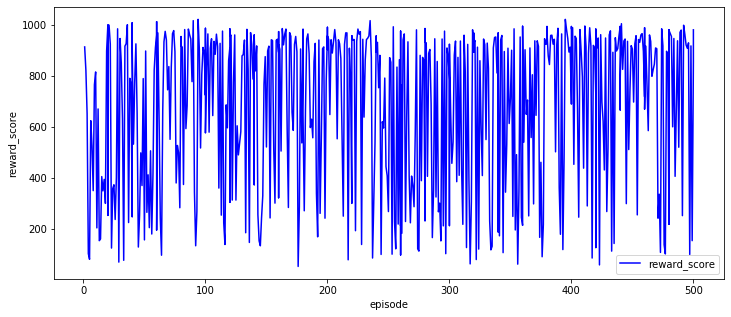

In [93]:
%matplotlib inline
import pandas as pd
import json

training_metrics_file = "training_metrics.json"
training_metrics_path = "{}/{}".format(s3_prefix, training_metrics_file)
wait_for_s3_object(s3_bucket, training_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, training_metrics_file)
with open(json_file) as fp:  
    data = json.load(fp)

df = pd.DataFrame(data['metrics'])
x_axis = 'episode'
y_axis = 'reward_score'

plt = df.plot(x=x_axis,y=y_axis, figsize=(12,5), legend=True, style='b-')
plt.set_ylabel(y_axis);
plt.set_xlabel(x_axis);

### Clean up RoboMaker and SageMaker training job

Execute the cells below if you want to kill RoboMaker and SageMaker job.

In [154]:
# # Cancelling robomaker job
# for job_arn in job_arns:
#     robomaker.cancel_simulation_job(job=job_arn)

# # Stopping sagemaker training job
# sage_session.sagemaker_client.stop_training_job(TrainingJobName=estimator._current_job_name)

{'ResponseMetadata': {'RequestId': '8a02bcf8-3cf5-4231-b713-f0f40f33e774',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '8a02bcf8-3cf5-4231-b713-f0f40f33e774',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Sat, 17 Apr 2021 04:30:02 GMT'},
  'RetryAttempts': 0}}

# Evaluation (Time trail, Object avoidance, Head to bot)

In [63]:
s3_yaml_name="evaluation_params.yaml"
world_name = "reInvent2019_track"
# world_name = "Monaco_building"

with open("./src/artifacts/yaml/evaluation_yaml_template.yaml", "r") as filepointer:
    yaml_config = yaml.load(filepointer)

yaml_config['WORLD_NAME']                  = world_name
yaml_config['MODEL_S3_BUCKET']             = s3_bucket
yaml_config['MODEL_S3_PREFIX']             = s3_prefix
yaml_config['AWS_REGION']                  = aws_region
yaml_config['METRICS_S3_BUCKET']           = s3_bucket
yaml_config['METRICS_S3_OBJECT_KEY']       = "{}/evaluation_metrics.json".format(s3_prefix)
yaml_config['SIMTRACE_S3_BUCKET']          = s3_bucket
yaml_config['SIMTRACE_S3_PREFIX']          = "{}/iteration-data/evaluation".format(s3_prefix)
yaml_config['ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID'] = account_id
yaml_config['NUMBER_OF_TRIALS']            = "10"
yaml_config['MP4_S3_BUCKET']               = s3_bucket
yaml_config['DISPLAY_NAME']                = "FreireBros"
yaml_config['RACER_NAME']                  = "FreireBros"
yaml_config['MODEL_NAME']                  = "Shallow-Model-8"
yaml_config['LEADERBOARD_TYPE']            = "LEAGUE"
yaml_config['LEADERBOARD_NAME']            = "APRIL QUALIFIER"
yaml_config['MP4_S3_OBJECT_PREFIX']        = "{}/iteration-data/evaluation".format(s3_prefix)


# Race-type supported for training are TIME_TRIAL, OBJECT_AVOIDANCE, HEAD_TO_BOT
# If you need to modify more attributes look at the template yaml file
race_type = "TIME_TRIAL"

if race_type == "OBJECT_AVOIDANCE":
    yaml_config['NUMBER_OF_OBSTACLES']     = "6"
    yaml_config['RACE_TYPE']               = "OBJECT_AVOIDANCE"

elif race_type == "HEAD_TO_BOT":
    yaml_config['NUMBER_OF_BOT_CARS']      = "6"
    yaml_config['RACE_TYPE']               = "HEAD_TO_BOT"

# Printing the modified yaml parameter
for key, value in yaml_config.items():
    print("{}: {}".format(key.ljust(40, ' '), value))

# Uploading the modified yaml parameter
with open("./evaluation_params.yaml", "w") as filepointer:
    yaml.dump(yaml_config, filepointer)

!aws s3 cp ./evaluation_params.yaml {s3_location}/evaluation_params.yaml
!rm evaluation_params.yaml

JOB_TYPE                                : EVALUATION
WORLD_NAME                              : Oval_track
MODEL_S3_BUCKET                         : freirebros-deepracer
MODEL_S3_PREFIX                         : AndreiModels/Model-Andrei-Final-4-Architecture-gpu
AWS_REGION                              : us-east-1
METRICS_S3_BUCKET                       : freirebros-deepracer
METRICS_S3_OBJECT_KEY                   : AndreiModels/Model-Andrei-Final-4-Architecture-gpu/evaluation_metrics.json
SIMTRACE_S3_BUCKET                      : freirebros-deepracer
SIMTRACE_S3_PREFIX                      : AndreiModels/Model-Andrei-Final-4-Architecture-gpu/iteration-data/evaluation
NUMBER_OF_TRIALS                        : 10
ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID     : 204747776045
CAR_COLOR                               : Grey
NUMBER_OF_RESETS                        : 10000
PENALTY_SECONDS                         : 2.0
IS_CONTINUOUS                           : false
OFF_TRACK_PENALTY                  

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


upload: ./evaluation_params.yaml to s3://freirebros-deepracer/AndreiModels/Model-Andrei-Final-4-Architecture-gpu/evaluation_params.yaml


In [64]:
num_simulation_workers = 1

envriron_vars = {
    "S3_YAML_NAME": s3_yaml_name,
    "MODEL_S3_PREFIX": s3_prefix,
    "MODEL_S3_BUCKET": s3_bucket,
    "WORLD_NAME": world_name,
    "KINESIS_VIDEO_STREAM_NAME": kvs_stream_name,
    "APP_REGION": aws_region,
    "MODEL_METADATA_FILE_S3_KEY": "%s/model/model_metadata.json" % s3_prefix
}

simulation_application = {
    "application":simulation_app_arn,
    "launchConfig": {
         "packageName": "deepracer_simulation_environment",
         "launchFile": "evaluation.launch",
         "environmentVariables": envriron_vars
    }
}
                            
vpcConfig = {"subnets": deepracer_subnets,
             "securityGroups": deepracer_security_groups,
             "assignPublicIp": True}

responses = []
for job_no in range(num_simulation_workers):
    response =  robomaker.create_simulation_job(clientRequestToken=strftime("%Y-%m-%d-%H-%M-%S", gmtime()),
                                                outputLocation={ 
                                                  "s3Bucket": s3_bucket,
                                                  "s3Prefix": s3_prefix
                                                },
                                                maxJobDurationInSeconds=job_duration_in_seconds,
                                                iamRole=sagemaker_role,
                                                failureBehavior="Fail",
                                                simulationApplications=[simulation_application],
                                                vpcConfig=vpcConfig)
    responses.append(response)

print("Created the following jobs:")
job_arns = [response["arn"] for response in responses]
for job_arn in job_arns:
    print("Job ARN", job_arn)

Created the following jobs:
Job ARN arn:aws:robomaker:us-east-1:204747776045:simulation-job/sim-pc3ps7sy54yl


### Visualizing the simulations in RoboMaker
You can visit the RoboMaker console to visualize the simulations or run the following cell to generate the hyperlinks.

In [65]:
display(Markdown(generate_robomaker_links(job_arns, aws_region)))

> Click on the following links for visualization of simulation jobs on RoboMaker Console
- [Simulation 1](https://us-east-1.console.aws.amazon.com/robomaker/home?region=us-east-1#simulationJobs/sim-pc3ps7sy54yl)  

You can click on Gazebo after you open the above link to start the simulator.

### Creating temporary folder top plot metrics

In [69]:
evaluation_metrics_file = "evaluation_metrics.json"
evaluation_metrics_path = "{}/{}".format(s3_prefix, evaluation_metrics_file)
wait_for_s3_object(s3_bucket, evaluation_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, evaluation_metrics_file)
with open(json_file) as fp:  
    data = json.load(fp)

df = pd.DataFrame(data['metrics'])
# Converting milliseconds to seconds
df['elapsed_time'] = df['elapsed_time_in_milliseconds']/1000
df = df[['trial', 'completion_percentage', 'elapsed_time','off_track_count']]

display(df)

Waiting for s3://freirebros-deepracer/AndreiModels/Model-Andrei-Final-4-Architecture-gpu/evaluation_metrics.json...


,trial,completion_percentage,elapsed_time,off_track_count
0,1,100,14.253,7
1,2,100,13.387,5
2,3,100,14.337,8
3,4,100,14.991,10
4,5,100,14.362,7
5,6,100,14.147,7
6,7,100,14.594,8
7,8,100,13.755,6
8,9,100,14.516,7
9,10,100,13.988,6


### Clean Up Simulation Application Resource

In [156]:
robomaker.delete_simulation_application(application=simulation_app_arn)

{'ResponseMetadata': {'RequestId': '2c68e349-5fdc-4bef-aa31-a2c1bcfee8ee',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Sat, 17 Apr 2021 04:30:36 GMT',
   'content-type': 'application/json',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': '2c68e349-5fdc-4bef-aa31-a2c1bcfee8ee',
   'x-amz-apigw-id': 'd6Sg9GPYIAMF-fA=',
   'x-amzn-trace-id': 'Root=1-607a646c-00d192f03fdf532c3a5e537a'},
  'RetryAttempts': 0}}

### Clean your S3 bucket (Uncomment the awscli commands if you want to do it)

In [155]:
# # Uncomment if you only want to clean the s3 bucket
# sagemaker_s3_folder = "s3://{}/{}".format(s3_bucket, s3_prefix)
# !aws s3 rm --recursive {sagemaker_s3_folder}

# robomaker_s3_folder = "s3://{}/{}".format(s3_bucket, job_name)
# !aws s3 rm --recursive {robomaker_s3_folder}

# robomaker_sim_app = "s3://{}/{}".format(s3_bucket, 'robomaker')
# !aws s3 rm --recursive {robomaker_sim_app}

# model_output = "s3://{}/{}".format(s3_bucket, s3_bucket)
# !aws s3 rm --recursive {model_output}

delete: s3://freirebros-deepracer/AndreiModels/Model-Andrei-Final-4-Architecture-gpu/iteration-data/training/camera-45degree/68-video.mp4
delete: s3://freirebros-deepracer/AndreiModels/Model-Andrei-Final-4-Architecture-gpu/customer_reward_function.py
delete: s3://freirebros-deepracer/AndreiModels/Model-Andrei-Final-4-Architecture-gpu/iteration-data/training/camera-pip/68-video.mp4
delete: s3://freirebros-deepracer/AndreiModels/Model-Andrei-Final-4-Architecture-gpu/model/180_Step-46639.ckpt.meta
delete: s3://freirebros-deepracer/AndreiModels/Model-Andrei-Final-4-Architecture-gpu/model/180_Step-46639.ckpt.index
delete: s3://freirebros-deepracer/AndreiModels/Model-Andrei-Final-4-Architecture-gpu/model/181_Step-46963.ckpt.meta
delete: s3://freirebros-deepracer/AndreiModels/Model-Andrei-Final-4-Architecture-gpu/iteration-data/training/training-simtrace/68-iteration.csv
delete: s3://freirebros-deepracer/AndreiModels/Model-Andrei-Final-4-Architecture-gpu/model/181_Step-46963.ckpt.index
delete

delete: s3://freirebros-deepracer/deepracer-notebook-2021-04-17-02-26-35-637/profiler-output/system/incremental/2021041703/1618629540.algo-1.json
delete: s3://freirebros-deepracer/deepracer-notebook-2021-04-17-02-26-35-637/profiler-output/system/incremental/2021041703/1618629660.algo-1.json
delete: s3://freirebros-deepracer/deepracer-notebook-2021-04-17-02-26-35-637/profiler-output/system/incremental/2021041703/1618629720.algo-1.json
delete: s3://freirebros-deepracer/deepracer-notebook-2021-04-17-02-26-35-637/profiler-output/system/incremental/2021041703/1618629480.algo-1.json
delete: s3://freirebros-deepracer/deepracer-notebook-2021-04-17-02-26-35-637/profiler-output/system/incremental/2021041703/1618628520.algo-1.json
delete: s3://freirebros-deepracer/deepracer-notebook-2021-04-17-02-26-35-637/profiler-output/system/incremental/2021041703/1618629120.algo-1.json
delete: s3://freirebros-deepracer/deepracer-notebook-2021-04-17-02-26-35-637/profiler-output/system/incremental/2021041703/1

delete: s3://freirebros-deepracer/deepracer-notebook-2021-04-17-02-26-35-637/profiler-output/system/incremental/2021041704/1618633380.algo-1.json
delete: s3://freirebros-deepracer/deepracer-notebook-2021-04-17-02-26-35-637/profiler-output/system/incremental/2021041704/1618633620.algo-1.json
delete: s3://freirebros-deepracer/deepracer-notebook-2021-04-17-02-26-35-637/profiler-output/system/incremental/2021041704/1618633500.algo-1.json
delete: s3://freirebros-deepracer/deepracer-notebook-2021-04-17-02-26-35-637/profiler-output/system/incremental/2021041704/1618633560.algo-1.json
delete: s3://freirebros-deepracer/deepracer-notebook-2021-04-17-02-26-35-637/profiler-output/system/incremental/2021041704/1618633740.algo-1.json
delete: s3://freirebros-deepracer/deepracer-notebook-2021-04-17-02-26-35-637/rule-output/ProfilerReport-1618626395/profiler-output/profiler-report.ipynb
delete: s3://freirebros-deepracer/deepracer-notebook-2021-04-17-02-26-35-637/rule-output/ProfilerReport-1618626395/pr

## DO NOT RUN - Get latest markov package from the bundle to run on SageMaker instance
This is no longer needed because we already implemented this step and have made modification
Should Delete this....

In [ ]:
# #
# # Run these commands only for the first time
# #
# # Clean the build directory if present
# !python3 sim_app_bundler.py --clean

# # Download Robomaker simApp from the deepracer public s3 bucket
# simulation_application_bundle_location = "s3://deepracer-managed-resources-us-east-1/deepracer-simapp.tar.gz"
# !aws s3 cp {simulation_application_bundle_location} ./deepracer-simapp.tar.gz

# # Untar the simapp bundle
# !python3 sim_app_bundler.py --untar ./deepracer-simapp.tar.gz

# !rm -rf ./src/markov
# !cp -r build/simapp/bundle/opt/install/sagemaker_rl_agent/lib/python3.5/site-packages/markov ./src/

# # Remove build & deepracer-simapp.tar.gz
# !rm -rf build
# !rm -rf deepracer-simapp.tar.gz